In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp, quad
from scipy import optimize
from IPython.display import display, Latex
import cmath
from tqdm import tqdm

In [ ]:
\eta/\epsilon=0.1/0.25=0.4
r_range=[0.22,1.207]

In [2]:
def V1(phi,r):
    v=phi*(phi+2*r)/(1+(r+phi)**2)
    return v

def V0(phi,r):
    v=phi-(r**2+1)*np.arctan(r+phi)
    return v

def V2(phi,r):
    v=2*(phi+r)*(1+r**2)/(1+(r+phi)**2)**2
    return v

def ret_root(r,E):
    E_min=-(r**2+1)*np.arctan(r)
    E_max=(r**2+1)*np.arctan(r)-2*r
    Error_msg="Bro! pick the energy between the max {2}  and min {3},got :{0} for r:{1} ".format(E,r,E_max,E_min)
    assert E<E_max and E>E_min, Error_msg
    root=[]
    i=0
    while len(root)<2 and i<100:
        x0=(2*np.random.rand()-1)*2*r
        x = np.round(optimize.newton(lambda x,r : V0(x,r)-E, x0, fprime=V1,fprime2=V2,args=(r,)),4)
        if x>-2*r and x not in root:
            root.append(x)
        i+=1
    root=np.sort(root)
    return root

def calc_T(V0,r,E):
    roots=ret_root(r,E)
    if len(roots)==1:
        print("roots not found properply")
        return
#     print(roots)
    th=1e-4
    N=1000
    x=np.linspace(roots[0],roots[1],N)[1:-1]
    y=(2*(E-V0(x,r)))**-0.5
#     d=2*np.trapz(y,x)
    d=2*quad(lambda x,r,E : (-2*(V0(x,r)-E))**-0.5,roots[0]+th,roots[1]-th,args=(r,E))[0]

    return d

def damp_coeff(t,T,A,r=1):
    #x=-2*r
    x=0
    psi=x+A*np.cos(2*np.pi*t/T)
    y=((1+r**2)*(r+psi)/(1+(r+psi)**2)**3)
    return y/T

def amplification_info(eta,ohm,disp=True):
    eta_max=3**(1.5)/(ohm*8)
    if disp: display(Latex("$\eta_{max}=$"+str(eta_max)))
    f=lambda r: eta*ohm*(1+r**2)**2-2*r
    if eta>=eta_max:
        if disp: print("amplification not possible, select eta<",eta_max)
        return

    root=[]
    i=0
    while len(root)<2 and i<10:
        x0=(2*np.random.rand()-1)*1e-1+3**-0.5
        x = np.round(optimize.newton(f, x0, fprime=lambda r : eta*ohm*4*r*(1+r**2)-2),4)
        if x not in root:
            root.append(x)
        i+=1
    
    if len(root)==1: 
        if disp:print("only one root found so trying bisection method")
        root=[]
        
        root.append(optimize.bisect(f,0,3**-0.5))
        right=10
        while np.sign(f(right))==-1:
            right+=10
        root.append(optimize.bisect(f,3**-0.5,right))
        
    root=np.sort(root)
    return root

def mirror_2d(t,z,ohm,r,eta):
    phi,phi_d=z
    #phi_d_dot=1
    phi_d_dot=-2*(eta-(2*(1+r**2)*(r+phi))/(ohm*(1+(r+phi)**2)**3))*phi_d-(phi*(phi+2*r))/(1+(r+phi)**2)
    phi_dot=phi_d
    return phi_dot,phi_d_dot
    
def evolve(psi_0,tf,param_list,N_step=100,f=mirror_2d,rtol = 1e-7, atol = 1e-7):
    t = np.linspace(0,tf,N_step)
    #xx=solve_ivp(ODE, [0,tf],psi_0,args=param_list,dense_output=True, t_eval=t,method="RK23")
    xx=solve_ivp(f, [0,tf],psi_0,args=param_list,dense_output=False,rtol = rtol, atol = atol, t_eval=t,method="BDF")
#     zz=xx.sol(t)
    zz=xx.y

    return zz,t

def mirror_4d(t,z,ohm,r,eta):
    phi,phi_d,w,y=z
    phi_d_dot=w**2+y**2+2*w-2*eta*phi_d
    phi_dot=phi_d
    w_dot=-ohm*(w+y*(r+phi))
    y_dot=ohm*(w*(r+phi)+phi-y)
    return phi_dot,phi_d_dot,w_dot,y_dot

def lyapunov(x0,y0,ohm,r,eta):
    F=lambda x: x*(x+2*r)/(1+(r+x)**2)
    A=lambda x: 2*(eta-2*(1+r**2)*(x+r)/(ohm*(1+(x+r)**2)**3))
    A1=lambda x: -4*(1+r**2)*((r+x-1)**2-(r+x))/(ohm*(1+(r+x)**2)**4) 
    D=A(x0)**2-4*(F(x0)+A1(x0)*y0)
    lam1=(-A(x0)+cmath.sqrt(D))/2
    lam2=(-A(x0)-cmath.sqrt(D))/2
    return [lam1,lam2]



<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.21978973 1.20683863]
gamma_0= -0.06


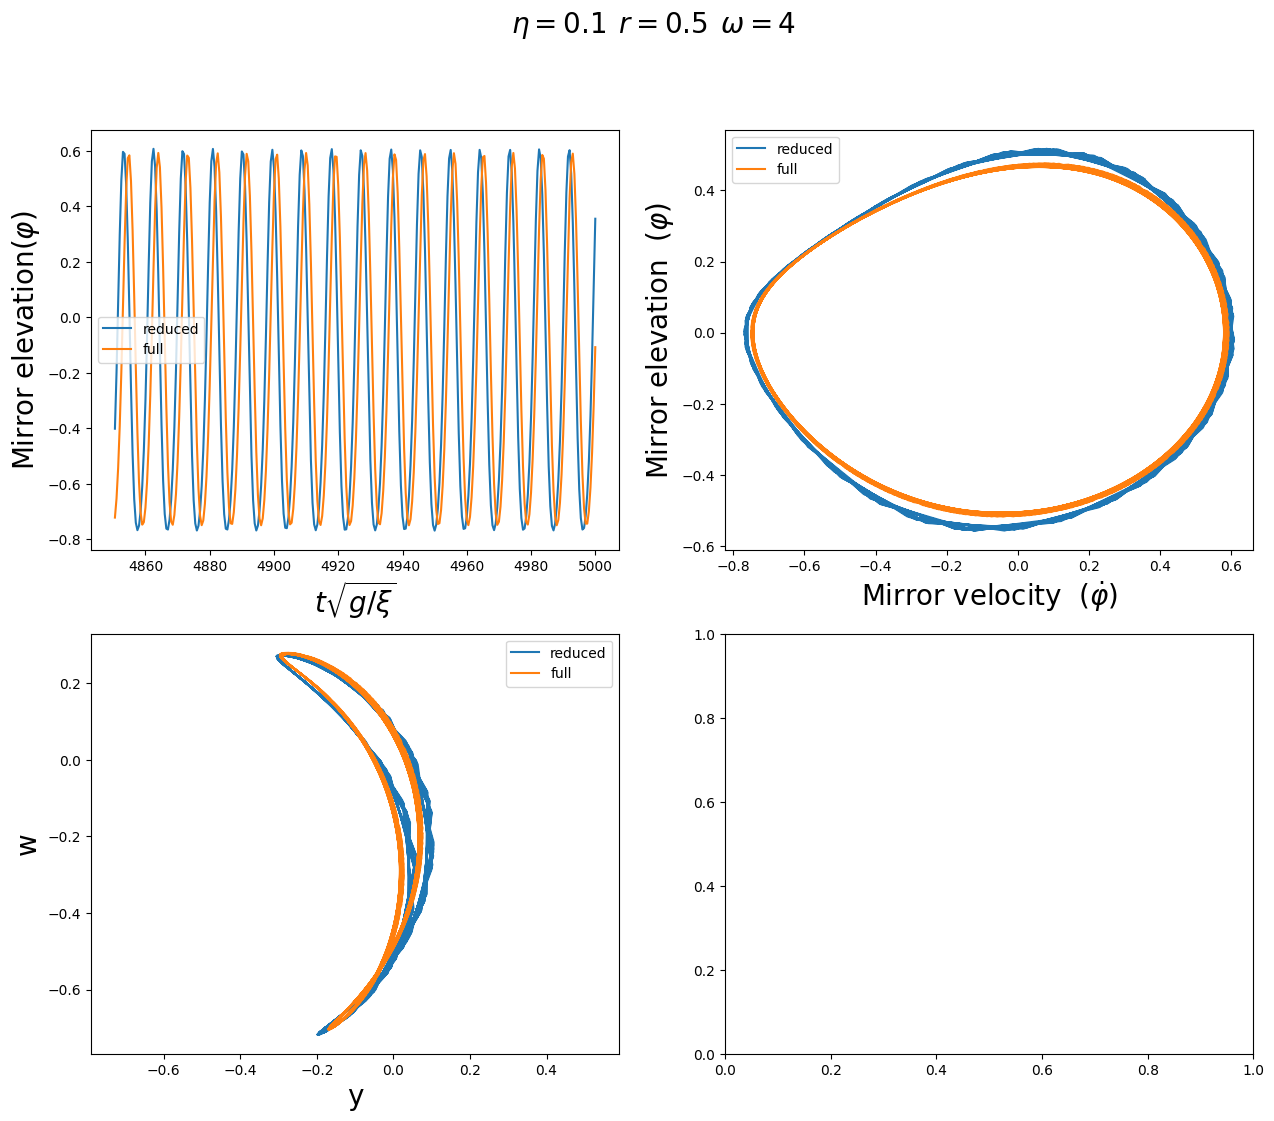

In [23]:
eta=0.1
ohm=4
r=0.5
# r=3**-0.5
r_range=amplification_info(eta,ohm)
print("r_range=",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0=",gamma_0)
   
tf=5e3              ### DO NOT increase this by a lot
N_step=1000*10

phi_0,phi_d_0=1e-3,0
psi_0=np.array([phi_0,phi_d_0])
psi_0_f=np.array([phi_0,phi_d_0,0,0])

param_list=[ohm,r,eta] 
zz_0,t=evolve(psi_0,tf,param_list,N_step)
zz_1,t=evolve(psi_0_f,tf,param_list,N_step,f=mirror_4d)

fig, axs = plt.subplots(2, 2,figsize=(15,12))

f_range=[int(0.97*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
i=0
axs[i//2,i%2].plot(t[f_range[0]:f_range[1]],zz_0[0][f_range[0]:f_range[1]],label='reduced')
axs[i//2,i%2].plot(t[f_range[0]:f_range[1]],zz_1[0][f_range[0]:f_range[1]],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("Mirror elevation"+"$(\\varphi)$",fontsize=20)
axs[i//2,i%2].set_xlabel('$t\sqrt{g/\\xi}$',fontsize=20)
i=1
axs[i//2,i%2].plot(zz_0[0][f_range[0]:f_range[1]],zz_0[1][f_range[0]:f_range[1]],label='reduced')
axs[i//2,i%2].plot(zz_1[0][f_range[0]:f_range[1]],zz_1[1][f_range[0]:f_range[1]],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("Mirror elevation  "+"$(\\varphi)$",fontsize=20)
axs[i//2,i%2].set_xlabel("Mirror velocity  "+"$(\dot{\\varphi})$",fontsize=20)
axs[i//2,i%2].axis("equal")
i=2
w_0=-(zz_0[0]*(r+zz_0[0]))/(1+(r+zz_0[0])**2)
y_0=zz_0[0]/(1+(r+zz_0[0])**2)
w_1=((1+r**2)*(2*r+3*zz_0[0])-zz_0[0]**3)/(1+(r+zz_0[0])**2)**3
y_1=((r+zz_0[0])*(r*(r+zz_0[0])**2+3*zz_0[0])-1)/(1+(r+zz_0[0])**2)**3
w=w_0+zz_0[1]*w_1/ohm
y=y_0+zz_0[1]*y_1/ohm
axs[i//2,i%2].plot(w[f_range[0]:f_range[1]],y[f_range[0]:f_range[1]],label='reduced')
axs[i//2,i%2].plot(zz_1[2][f_range[0]:f_range[1]],zz_1[3][f_range[0]:f_range[1]],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("w",fontsize=20)
axs[i//2,i%2].set_xlabel("y",fontsize=20)
axs[i//2,i%2].axis("equal")
plt.suptitle("$\eta={0} \: \: r={1} \: \: \omega={2}$".format(eta,r,ohm),fontsize=20)
plt.show() 

<IPython.core.display.Latex object>

r_range= [0.4084 0.7876]
gamma_0= -0.0020000000000000018


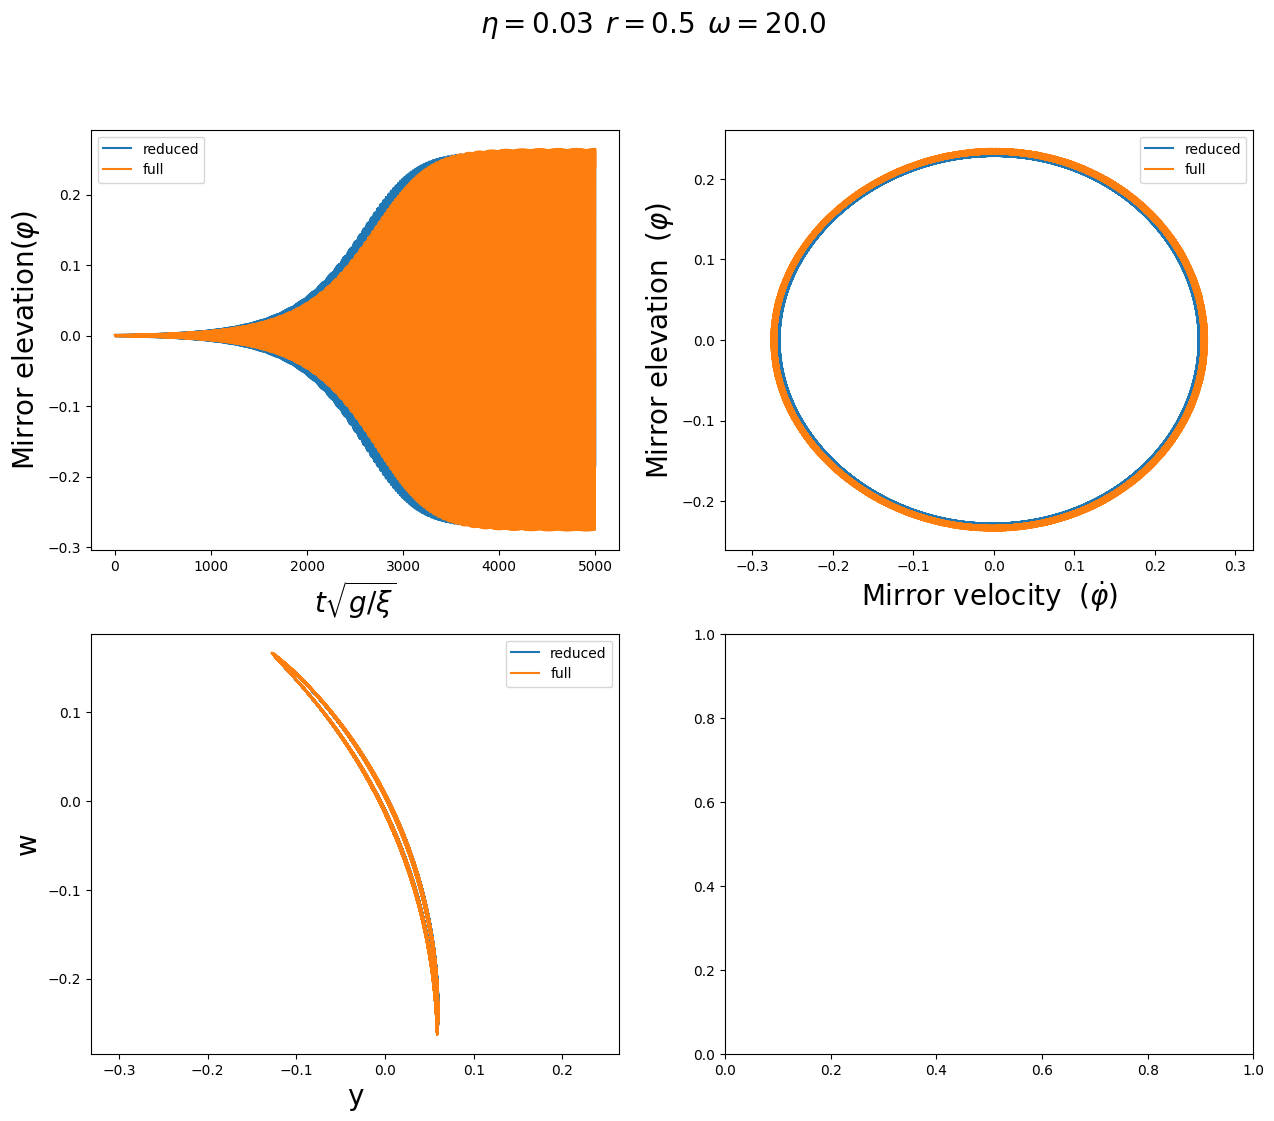

In [26]:
eta=0.03
ohm=2e1
r=0.5
# r=3**-0.5
r_range=amplification_info(eta,ohm)
print("r_range=",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0=",gamma_0)
   
tf=5e3              ### DO NOT increase this by a lot
N_step=1000*10

phi_0,phi_d_0=1e-3,0
psi_0=np.array([phi_0,phi_d_0])
psi_0_f=np.array([phi_0,phi_d_0,0,0])

param_list=[ohm,r,eta] 
zz_0,t=evolve(psi_0,tf,param_list,N_step)
zz_1,t=evolve(psi_0_f,tf,param_list,N_step,f=mirror_4d)

fig, axs = plt.subplots(2, 2,figsize=(15,12))

f_range=[int(0.9*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
i=0
axs[i//2,i%2].plot(t,zz_0[0],label='reduced')
axs[i//2,i%2].plot(t,zz_1[0],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("Mirror elevation"+"$(\\varphi)$",fontsize=20)
axs[i//2,i%2].set_xlabel('$t\sqrt{g/\\xi}$',fontsize=20)
i=1
axs[i//2,i%2].plot(zz_0[0][f_range[0]:f_range[1]],zz_0[1][f_range[0]:f_range[1]],label='reduced')
axs[i//2,i%2].plot(zz_1[0][f_range[0]:f_range[1]],zz_1[1][f_range[0]:f_range[1]],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("Mirror elevation  "+"$(\\varphi)$",fontsize=20)
axs[i//2,i%2].set_xlabel("Mirror velocity  "+"$(\dot{\\varphi})$",fontsize=20)
axs[i//2,i%2].axis("equal")
i=2
w_0=-(zz_0[0]*(r+zz_0[0]))/(1+(r+zz_0[0])**2)
y_0=zz_0[0]/(1+(r+zz_0[0])**2)
w_1=((1+r**2)*(2*r+3*zz_0[0])-zz_0[0]**3)/(1+(r+zz_0[0])**2)**3
y_1=((r+zz_0[0])*(r*(r+zz_0[0])**2+3*zz_0[0])-1)/(1+(r+zz_0[0])**2)**3
w=w_0+zz_0[1]*w_1/ohm
y=y_0+zz_0[1]*y_1/ohm
axs[i//2,i%2].plot(w[f_range[0]:f_range[1]],y[f_range[0]:f_range[1]],label='reduced')
axs[i//2,i%2].plot(zz_1[2][f_range[0]:f_range[1]],zz_1[3][f_range[0]:f_range[1]],label='full')
axs[i//2,i%2].legend()
axs[i//2,i%2].set_ylabel("w",fontsize=20)
axs[i//2,i%2].set_xlabel("y",fontsize=20)
axs[i//2,i%2].axis("equal")
plt.suptitle("$\eta={0} \: \: r={1} \: \: \omega={2}$".format(eta,r,ohm),fontsize=20)
plt.show() 

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.02001603 3.49583907]
gamma_0= -0.003978073788592567


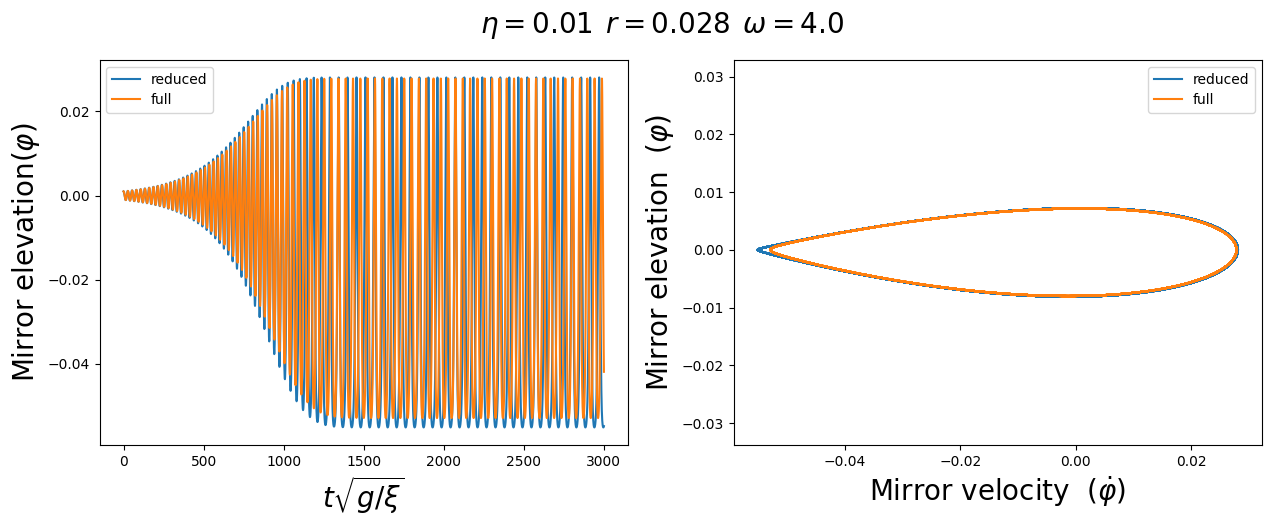

In [9]:
eta=0.01
ohm=4e0
r=0.028
# r=3**-0.5
r_range=amplification_info(eta,ohm)
print("r_range=",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0=",gamma_0)
   
tf=3e3              ### DO NOT increase this by a lot
# tf=3e3
N_step=1000*10
f_range=[int(0.8*N_step),N_step]

phi_0,phi_d_0=1e-3,0
psi_0=np.array([phi_0,phi_d_0])
psi_0_f=np.array([phi_0,phi_d_0,0,0])

param_list=[ohm,r,eta] 
zz_0,t=evolve(psi_0,tf,param_list,N_step)
zz_1,t=evolve(psi_0_f,tf,param_list,N_step,f=mirror_4d)

fig, axs = plt.subplots(1, 2,figsize=(15,5))

f_range=[int(0.5*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
i=0
axs[i%2].plot(t,zz_0[0],label='reduced')
axs[i%2].plot(t,zz_1[0],label='full')
axs[i%2].legend()
axs[i%2].set_ylabel("Mirror elevation"+"$(\\varphi)$",fontsize=20)
axs[i%2].set_xlabel('$t\sqrt{g/\\xi}$',fontsize=20)
i=1
axs[i%2].plot(zz_0[0][f_range[0]:f_range[1]],zz_0[1][f_range[0]:f_range[1]],label='reduced')
axs[i%2].plot(zz_1[0][f_range[0]:f_range[1]],zz_1[1][f_range[0]:f_range[1]],label='full')
axs[i%2].legend()
axs[i%2].set_ylabel("Mirror elevation  "+"$(\\varphi)$",fontsize=20)
axs[i%2].set_xlabel("Mirror velocity  "+"$(\dot{\\varphi})$",fontsize=20)
axs[i%2].axis("equal")

plt.suptitle("$\eta={0} \: \: r={1} \: \: \omega={2}$".format(eta,r,ohm),fontsize=20)
plt.show() 

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.21978973 1.20683863]
gamma_0= -0.06


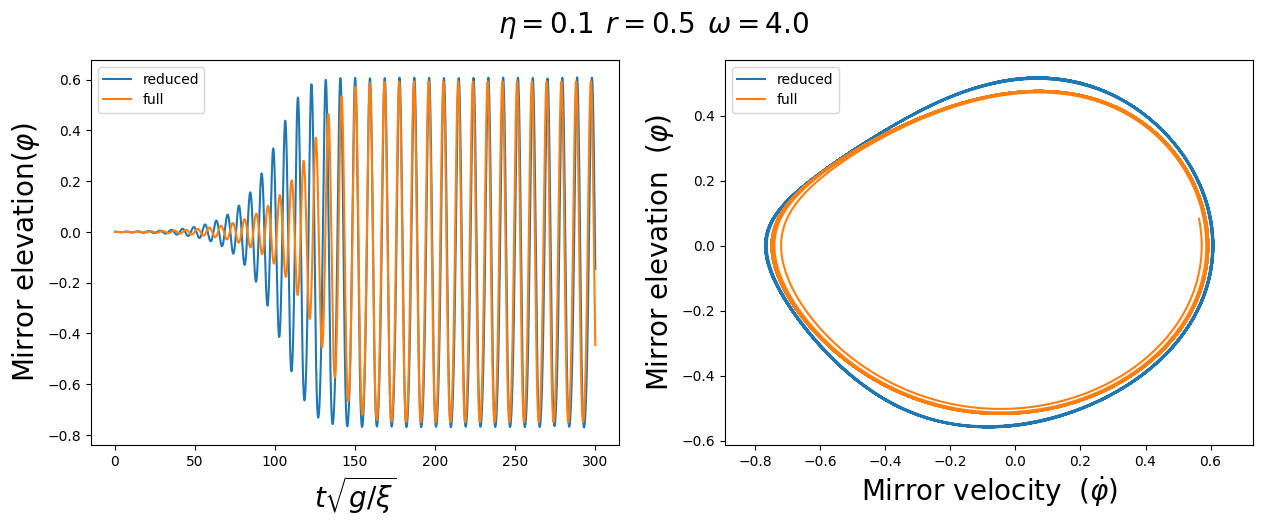

In [11]:
eta=0.1
ohm=4e0
r=0.5
# r=3**-0.5
r_range=amplification_info(eta,ohm)
print("r_range=",r_range)
if r<r_range[0] or r>r_range[1]:
    print("r out of range, select r to be in amplification regime")
gamma_0=eta-2*r/(ohm*(1+r**2)**2)
print("gamma_0=",gamma_0)
   
tf=3e2              ### DO NOT increase this by a lot
N_step=1000*10
f_range=[int(0.8*N_step),N_step]

phi_0,phi_d_0=1e-3,0
psi_0=np.array([phi_0,phi_d_0])
psi_0_f=np.array([phi_0,phi_d_0,0,0])

param_list=[ohm,r,eta] 
zz_0,t=evolve(psi_0,tf,param_list,N_step)
zz_1,t=evolve(psi_0_f,tf,param_list,N_step,f=mirror_4d)

fig, axs = plt.subplots(1, 2,figsize=(15,5))

f_range=[int(0.5*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
i=0
axs[i%2].plot(t,zz_0[0],label='reduced')
axs[i%2].plot(t,zz_1[0],label='full')
axs[i%2].legend()
axs[i%2].set_ylabel("Mirror elevation"+"$(\\varphi)$",fontsize=20)
axs[i%2].set_xlabel('$t\sqrt{g/\\xi}$',fontsize=20)
i=1
axs[i%2].plot(zz_0[0][f_range[0]:f_range[1]],zz_0[1][f_range[0]:f_range[1]],label='reduced')
axs[i%2].plot(zz_1[0][f_range[0]:f_range[1]],zz_1[1][f_range[0]:f_range[1]],label='full')
axs[i%2].legend()
axs[i%2].set_ylabel("Mirror elevation  "+"$(\\varphi)$",fontsize=20)
axs[i%2].set_xlabel("Mirror velocity  "+"$(\dot{\\varphi})$",fontsize=20)
axs[i%2].axis("equal")

plt.suptitle("$\eta={0} \: \: r={1} \: \: \omega={2}$".format(eta,r,ohm),fontsize=20)
plt.show() 

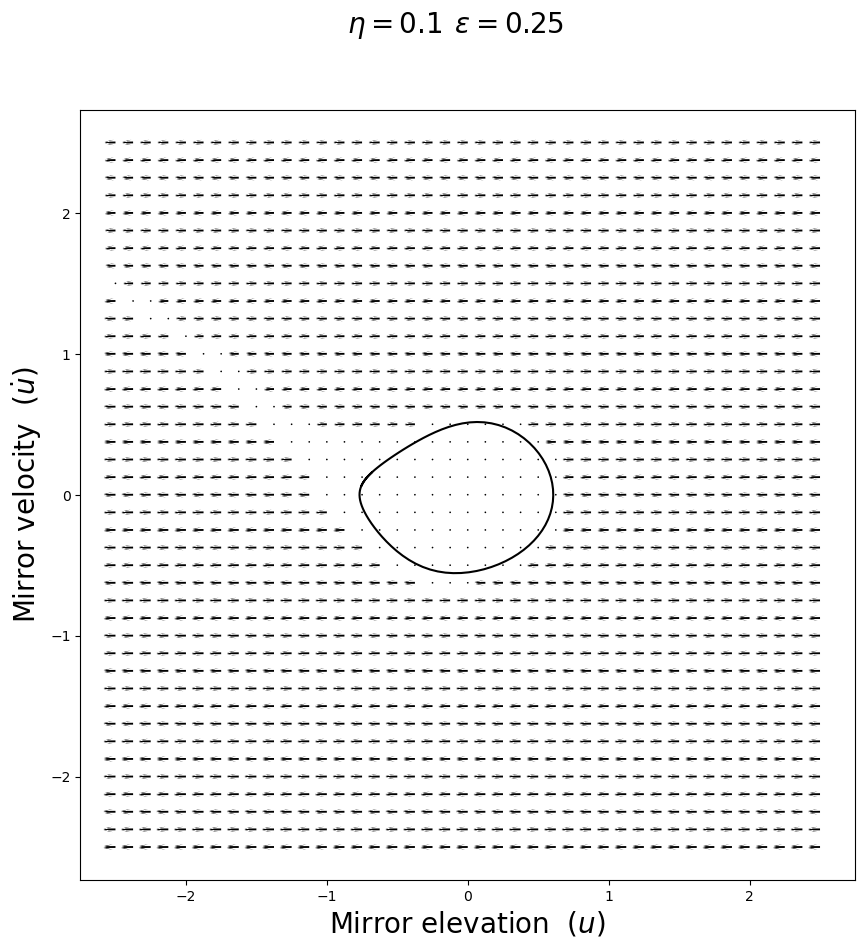

In [20]:
eta=0.1
ohm=4e0
r=0.5
tf=1e2
param_list=[ohm,r,eta] 

N_grid=41
N_step=2
x_0_list=np.linspace(-1,1,N_grid)*2.5
v_0_list=np.linspace(-1,1,N_grid)*2.5
origin=[]
dr=[]
for x_0 in x_0_list:
    for v_0 in v_0_list:
        phi_0=np.array([x_0,v_0])
        zz,t=evolve(phi_0,tf,param_list,N_step)
        origin.append([x_0,v_0])
        dr.append([zz[0][-1]-x_0,zz[1][-1]-v_0])

dr=np.array(dr)
origin=np.array(origin).T

Z1,t=evolve(np.array([1e-2,0]),1e3,param_list,10000)
plt.figure(figsize=(10,10))
plt.plot(Z1[0][9900:],Z1[1][9900:],color='k')
plt.quiver(*origin,dr[:,0],dr[:,1], color='k', headaxislength=0)
plt.axis('equal')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
plt.xlabel("Mirror elevation  "+"$(u)$",fontsize=20)
plt.ylabel("Mirror velocity  "+"$(\dot{u})$",fontsize=20)
plt.savefig("convergence_portrait.jpg")
plt.show()

eta_max= 0.03247595264191645


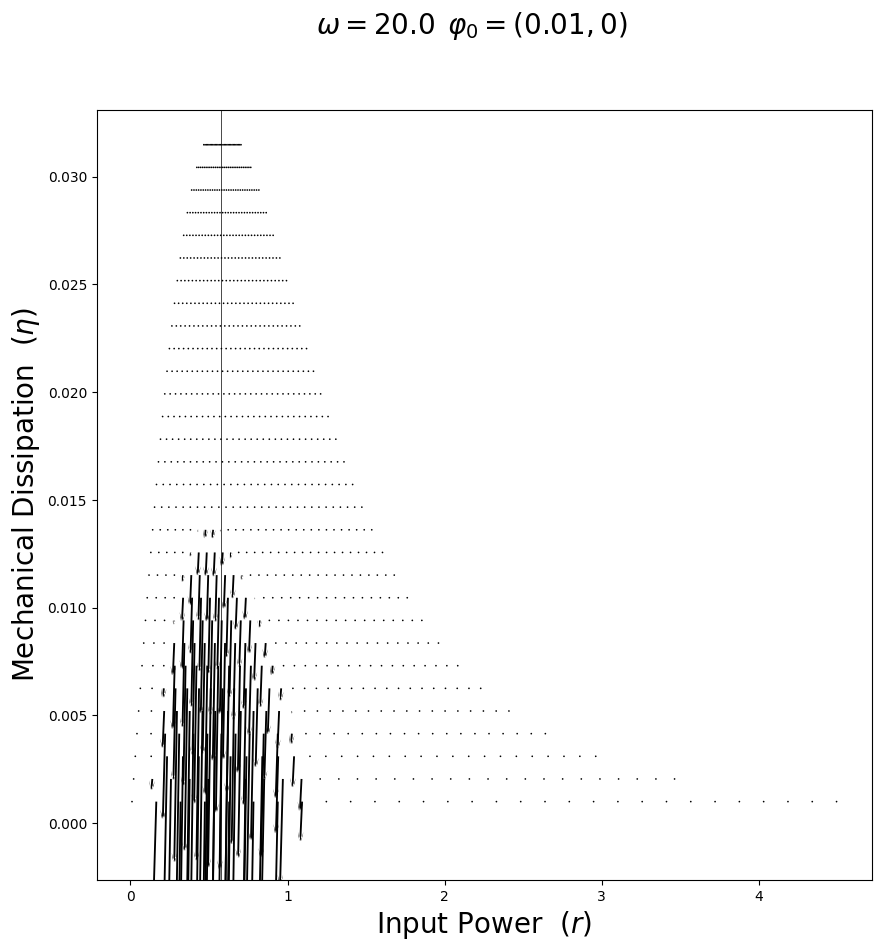

In [22]:
ohm=2e1
eta_max=3**(1.5)/(ohm*8)
print("eta_max=",eta_max)
tf=3e2

N_grid=30
N_step=2
eta_list=np.linspace(1e-3,eta_max-1e-3,N_grid)
phi_0=np.array([1e-2,0])
origin=[]
dr=[]
for eta in eta_list:
    r_range=amplification_info(eta,ohm,disp=False)
    r_list=np.linspace(r_range[0],r_range[1],N_grid)
    for r in r_list:
        param_list=[ohm,r,eta] 
        zz,t=evolve(phi_0,tf,param_list,N_step)
        origin.append([r,eta])
        dr.append([zz[1][-1],zz[0][-1]])
        
dr=np.array(dr)
origin=np.array(origin).T
quiveropts = dict(color='k', headlength=0, pivot='middle', scale=1, 
    linewidth=.01, units='xy', width=.01, headwidth=0.01) # common options

plt.figure(figsize=(10,10))
# plt.quiver(*origin,dr[:,0],dr[:,1], **quiveropts)
plt.quiver(*origin,dr[:,0],dr[:,1], color='k', headaxislength=0)
plt.axline((3**-0.5,1e-3), (3**-0.5, -1e-3),c='k',linewidth=0.5)

# plt.axis('equal')
#plt.plot(x_list,v_list,'o',color='k')
plt.suptitle("$\omega={0} \: \: \\varphi_0=(0.01,0) $".format(ohm),fontsize=20)
plt.xlabel("Input Power  "+"$(r)$",fontsize=20)
plt.ylabel("Mechanical Dissipation  "+"$(\eta)$",fontsize=20)
plt.show()

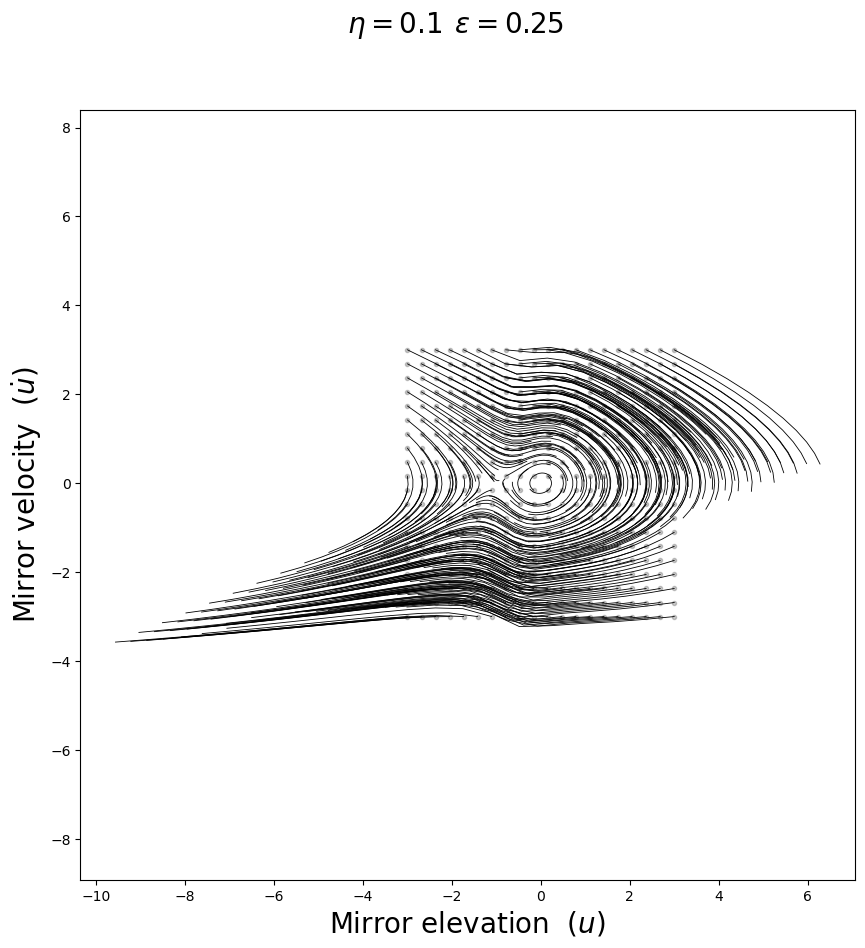

In [19]:
eta=0.1
ohm=4e0
r=0.5
param_list=[ohm,r,eta] 

tf=2e0              ### DO NOT increase this by a lot
N_step=10
N_grid=20
phi_0_list=np.linspace(-1,1,N_grid)*3
phi_d_0_list=np.linspace(-1,1,N_grid)*3

phi_list=[]
phi_d_list=[]
for phi_0 in phi_0_list:
    for phi_d_0 in phi_d_0_list:
        psi_0=np.array([phi_0,phi_d_0])
        zz,t=evolve(psi_0,tf,param_list,N_step)
        phi_list.append(zz[0])
        phi_d_list.append(zz[1])

phi_list=np.array(phi_list)
phi_d_list=np.array(phi_d_list)
# print(phi_list,phi_d_list)
plt.figure(figsize=(10,10))
plt.plot(phi_list.T,phi_d_list.T,color='k',linewidth=0.6)
plt.plot(phi_list.T[0],phi_d_list.T[0],'.',color='k',alpha=0.2)

plt.axis('equal')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
plt.xlabel("Mirror elevation  "+"$(u)$",fontsize=20)
plt.ylabel("Mirror velocity  "+"$(\dot{u})$",fontsize=20)
plt.savefig("phase_portrait.jpg")
plt.show()

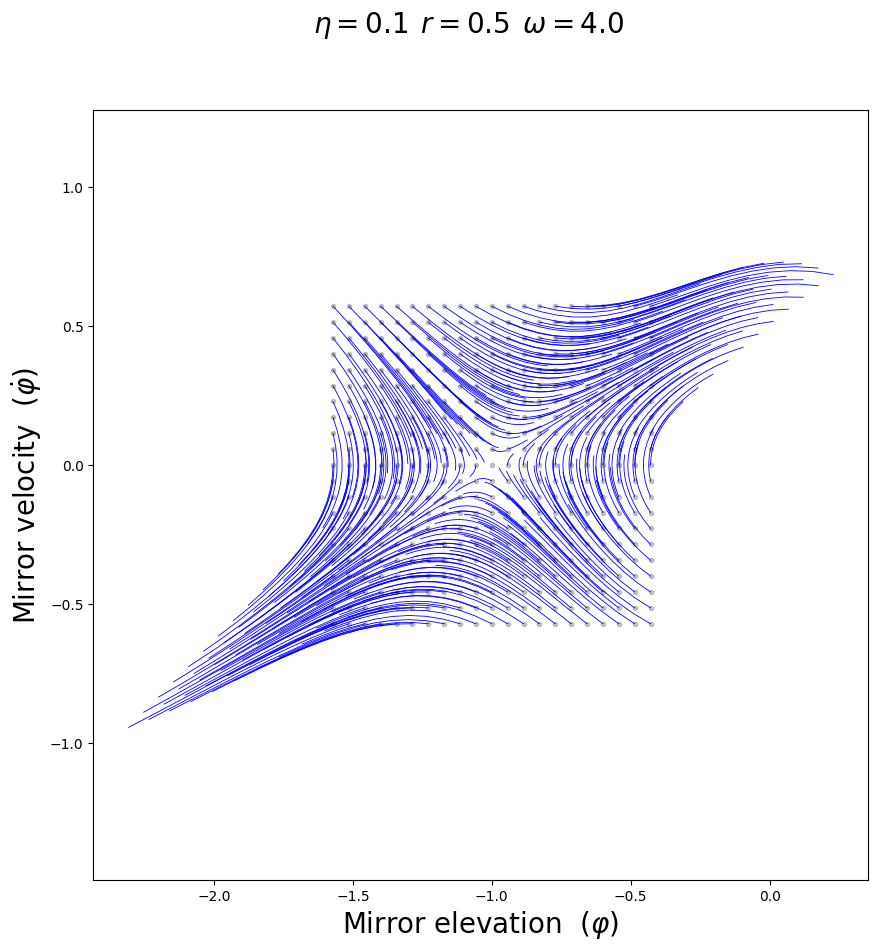

In [15]:
eta=0.1
ohm=4e0
r=0.5
param_list=[ohm,r,eta] 

tf=1e0              ### DO NOT increase this by a lot
N_step=10
N_grid=21
phi_0_list=np.linspace(-1+10/(N_grid),-1+18/(N_grid),N_grid)*3
phi_d_0_list=np.linspace(-4/(N_grid),4/(N_grid),N_grid)*3

phi_list=[]
phi_d_list=[]
for phi_0 in phi_0_list:
    for phi_d_0 in phi_d_0_list:
        psi_0=np.array([phi_0,phi_d_0])
        zz,t=evolve(psi_0,tf,param_list,N_step)
        phi_list.append(zz[0])
        phi_d_list.append(zz[1])

phi_list=np.array(phi_list)
phi_d_list=np.array(phi_d_list)
# print(phi_list,phi_d_list)
plt.figure(figsize=(10,10))
plt.plot(phi_list.T,phi_d_list.T,color='b',linewidth=0.6)
plt.plot(phi_list.T[0],phi_d_list.T[0],'.',color='k',alpha=0.2)

plt.axis('equal')
plt.suptitle("$\eta={0} \: \: r={1} \: \: \omega={2}$".format(eta,r,ohm),fontsize=20)
plt.xlabel("Mirror elevation  "+"$(\\varphi)$",fontsize=20)
plt.ylabel("Mirror velocity  "+"$(\dot{\\varphi})$",fontsize=20)
plt.show()

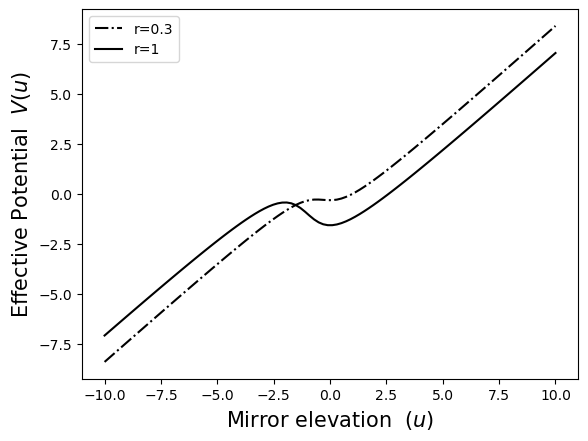

In [18]:
phi=np.linspace(-10,10,100)
# r_list=np.linspace(1,2,3)
r_list=[0.3,1]
y_list=[]
linestyle_list=['dashdot','solid']

for i,r in enumerate(r_list):
    plt.plot(phi,V0(phi,r),label='r={0}'.format(r),color='k',linestyle=linestyle_list[i])
plt.xlabel("Mirror elevation  "+"$(u)$",fontsize=15)
plt.ylabel("Effective Potential  "+"$V(u)$",fontsize=15)
plt.legend()
plt.savefig("Potential.jpg")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:12<00:00,  3.03s/it]


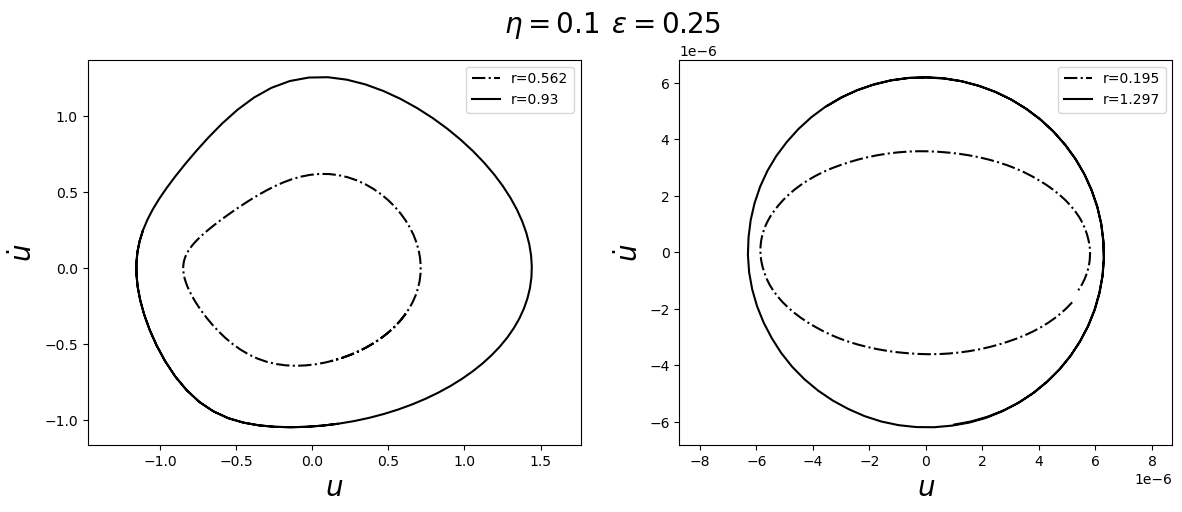

In [17]:
ohm=4e0
eta=0.1
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10

fig, axs = plt.subplots(1, 2,figsize=(14,5))
r_list=[0.562, 0.93,0.195,1.297]
psi_0=np.array([1e-2,0])
linestyle_list=['dashdot','solid']
sf=[9900,9900,9900,9900]
ef=10000
for i,r in enumerate(tqdm(r_list)):
    label="r={0}".format(r)
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    axs[i//2].plot(zz[0][sf[i]:ef],zz[1][sf[i]:ef],label=label,color='k',linestyle=linestyle_list[i%2])

axs[1].set_xlabel('$u$',fontsize=20)
axs[1].set_ylabel('$\dot{u}$',fontsize=20)

axs[1].axis("equal")
axs[1].legend(loc='best')
axs[0].set_xlabel('$u$',fontsize=20)
axs[0].set_ylabel('$\dot{u}$',fontsize=20)

axs[0].axis("equal")
axs[0].legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("phase_trajectories.jpg")

plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


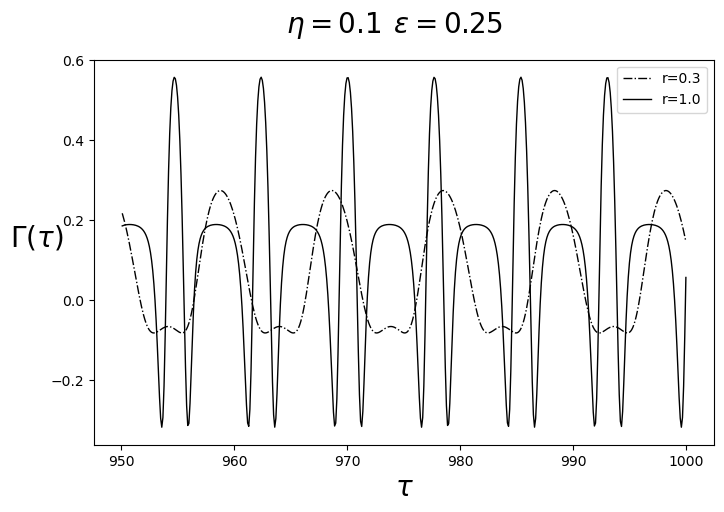

In [11]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10
phi_0,phi_d_0=1e-3,0
sf,ef=9500,10000
fig, axs = plt.subplots(1, 1,figsize=(8,5))
# r_list=[0.195,1.297 ]
r_list=[0.3,1.0]
linestyle_list=['dashdot','solid']
for i,r in enumerate(r_list):
    label="r={0}".format(r)
    psi_0=np.array([1e-2,0])
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step,rtol = 1e-9, atol = 1e-9)
    eff_gain=2*(eta-(2*(1+r**2)*(r+zz[0][sf:ef]))/(ohm*(1+(r+zz[0][sf:ef])**2)**3))

    axs.plot(t[sf:ef],eff_gain,label=label,linewidth=1,color='k',linestyle=linestyle_list[i])

axs.set_ylabel("$\Gamma(\\tau)$",fontsize=20, rotation=0,labelpad=10)
axs.set_xlabel('$\\tau$',fontsize=20)
axs.legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("effective_amplification.jpg")

plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


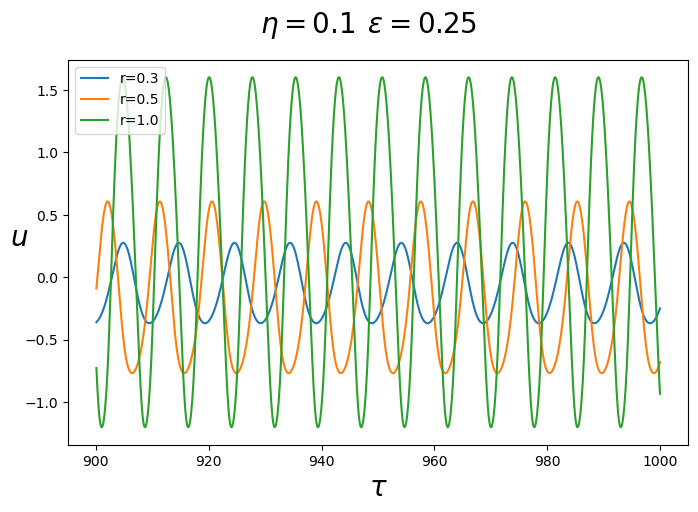

In [80]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(1, 1,figsize=(8,5))
# r_list=[0.93,0.562 ]
r_list=[0.3,0.5,1.0]

for r in r_list:
    label="r={0}".format(r)
    psi_0=np.array([1e-2,0])
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=(np.fft.fft(zz[0][f_range[0]:f_range[1]]))[:(f_range[1]-f_range[0])//32]/N_step
    axs.plot(t[9000:10000],zz[0][9000:10000],label=label)

axs.set_ylabel("$u$",fontsize=20, rotation=0)
axs.set_xlabel('$\\tau$',fontsize=20)
axs.legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("amplitude_steady_state.jpg")

plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


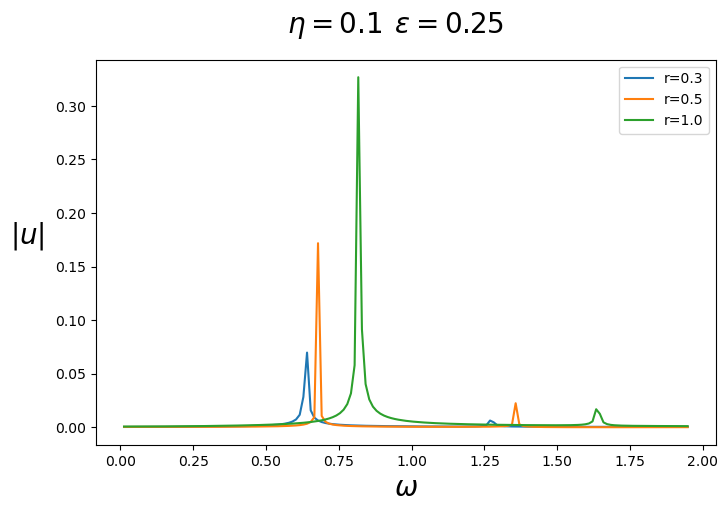

In [4]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10
f_range=[int(0.5*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange(1,(f_range[1]-f_range[0])//32)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(1, 1,figsize=(8,5))
# r_list=[0.93,0.562 ]
r_list=[0.3,0.5,1.0]

for r in r_list:
    label="r={0}".format(r)
    psi_0=np.array([1e-2,0])
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=(np.fft.fft(zz[0][f_range[0]:f_range[1]]))[1:(f_range[1]-f_range[0])//32]/N_step
    axs.plot(omega_list,np.abs(zz_f),label=label)

axs.set_ylabel("$|u|$",fontsize=20, rotation=0,labelpad=20)
axs.set_xlabel('$\omega$',fontsize=20)
axs.legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("fourier_steady_state.jpg")

plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


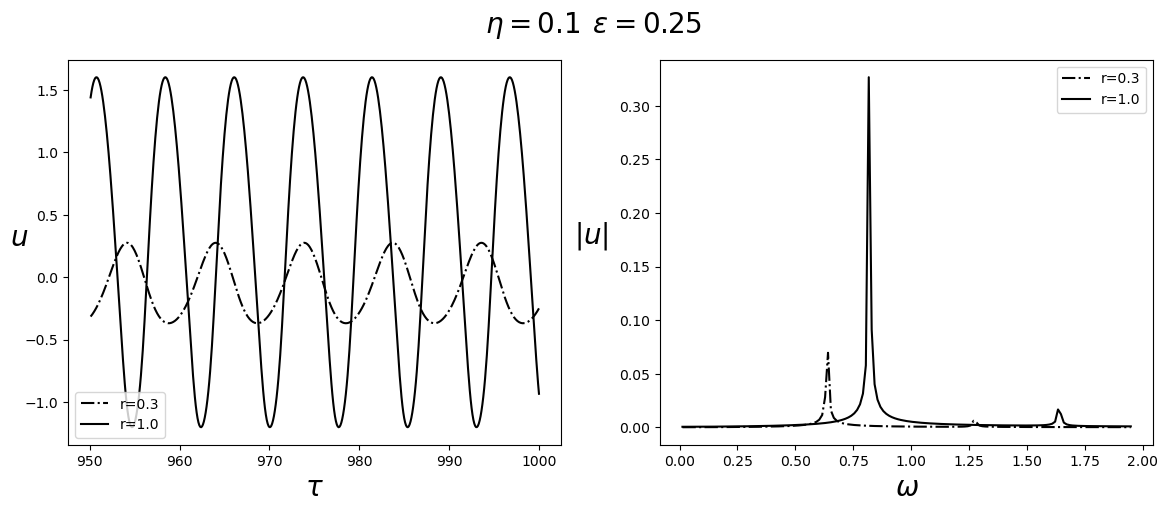

In [13]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10
f_range=[int(0.5*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange(1,(f_range[1]-f_range[0])//32)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(1, 2,figsize=(14,5))
N_grid=2
# r_list=np.round(np.linspace(r_range[0]+1e-3,r_range[1]-1e-3,N_grid),3)
# r_list=[0.93,0.562 ]
r_list=[0.3,1.0]
linestyle_list=['dashdot','solid']
sf,ef=9500,10000

for i,r in enumerate(r_list):
    label="r={0}".format(r)
    psi_0=np.array([1e-2,0])
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=(np.fft.fft(zz[0][f_range[0]:f_range[1]]))[1:(f_range[1]-f_range[0])//32]/N_step
    axs[1].plot(omega_list,np.abs(zz_f),label=label,color='k',linestyle=linestyle_list[i])
    axs[0].plot(t[sf:ef],zz[0][sf:ef],label=label,color='k',linestyle=linestyle_list[i])

axs[1].set_ylabel("$|u|$",fontsize=20, rotation=0,labelpad=20)
axs[1].set_xlabel('$\omega$',fontsize=20)
axs[1].legend(loc='best')
axs[0].set_ylabel("$u$",fontsize=20, rotation=0)
axs[0].set_xlabel('$\\tau$',fontsize=20)
axs[0].legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)
# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("phi_mirror_oscillations_steady_state.jpg")

plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


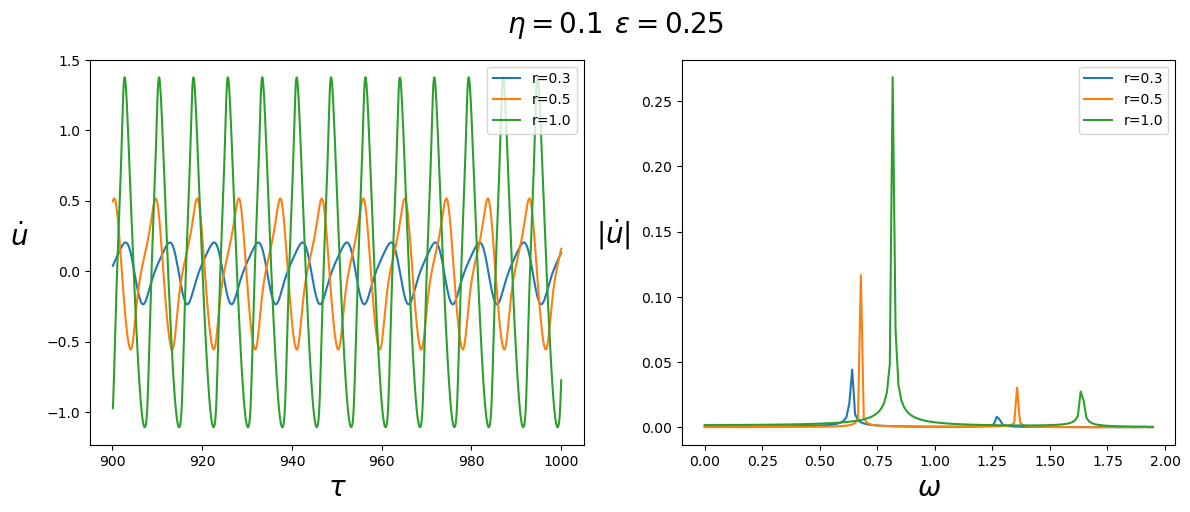

In [83]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=1e3             ### DO NOT increase this by a lot
N_step=1000*10
f_range=[int(0.5*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//32)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(1, 2,figsize=(14,5))
N_grid=2
# r_list=np.round(np.linspace(r_range[0]+1e-3,r_range[1]-1e-3,N_grid),3)
# r_list=[0.93,0.562 ]
r_list=[0.3,0.5,1.0]

for r in r_list:
    label="r={0}".format(r)
    psi_0=np.array([1e-2,0])
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=(np.fft.fft(zz[1][f_range[0]:f_range[1]]))[:(f_range[1]-f_range[0])//32]/N_step
    axs[1].plot(omega_list,np.abs(zz_f),label=label)
    axs[0].plot(t[9000:10000],zz[1][9000:10000],label=label)

axs[1].set_ylabel("$|\dot{u}|$",fontsize=20, rotation=0,labelpad=20)
axs[1].set_xlabel('$\omega$',fontsize=20)
axs[1].legend(loc='best')
axs[0].set_ylabel("$\dot{u}$",fontsize=20, rotation=0,labelpad=20)
axs[0].set_xlabel('$\\tau$',fontsize=20)
axs[0].legend(loc='best')
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)

# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("phi_dot_mirror_oscillations_steady_state.jpg")

plt.show()  

In [ ]:
i=0


<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.20it/s]


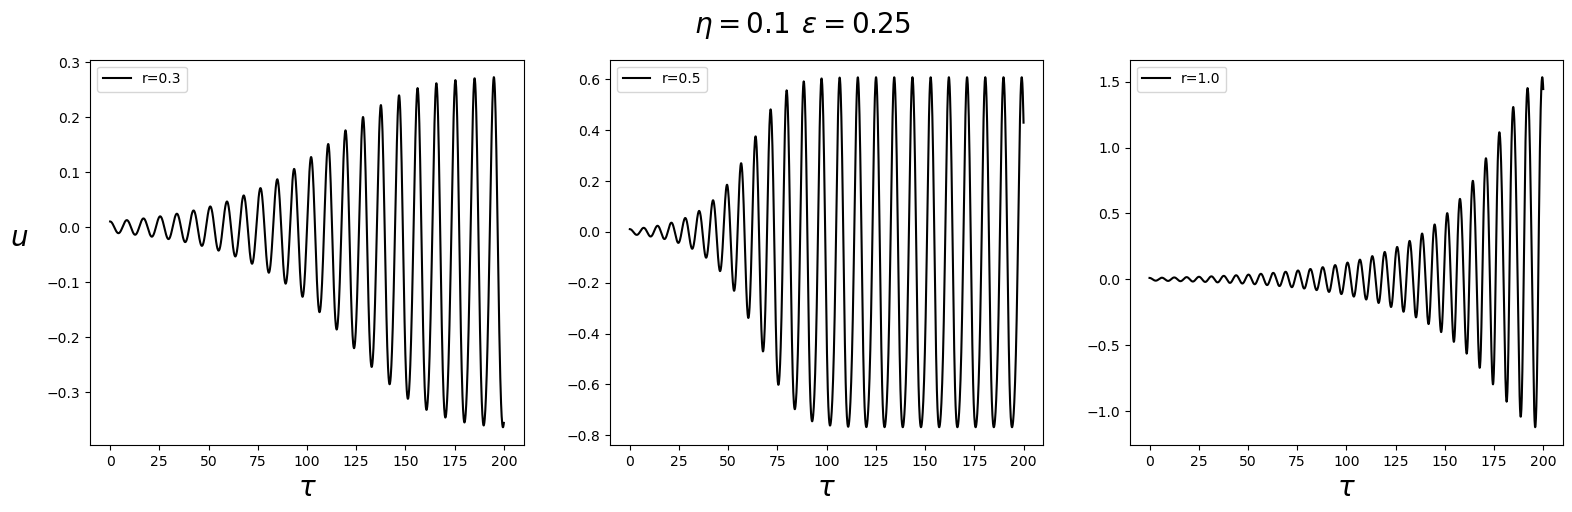

In [5]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=2e2             ### DO NOT increase this by a lot
N_step=1000*2
f_range=[int(0.8*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//8)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(1, 3,figsize=(19,5))
psi_0=np.array([1e-2,0])
r_list=[0.3,0.5,1.0]
for i,r in enumerate(tqdm(r_list)):
    label="r={0}".format(r)
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=np.abs(np.fft.fft(zz[0][f_range[0]:f_range[1]]))[:(f_range[1]-f_range[0])//8]/N_step
    axs[i].plot(t,zz[0],label=label,color='black')

#     axs[i].set_ylabel("$|\\varphi|$",fontsize=20)
    axs[i].set_xlabel('$\\tau$',fontsize=20)

    axs[i].legend(loc='best')

axs[0].set_ylabel("$u$",fontsize=20, rotation=0,labelpad=20)
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)

# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("time_evol_var_r"+str(i)+".jpg")
i+=1
plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.50it/s]


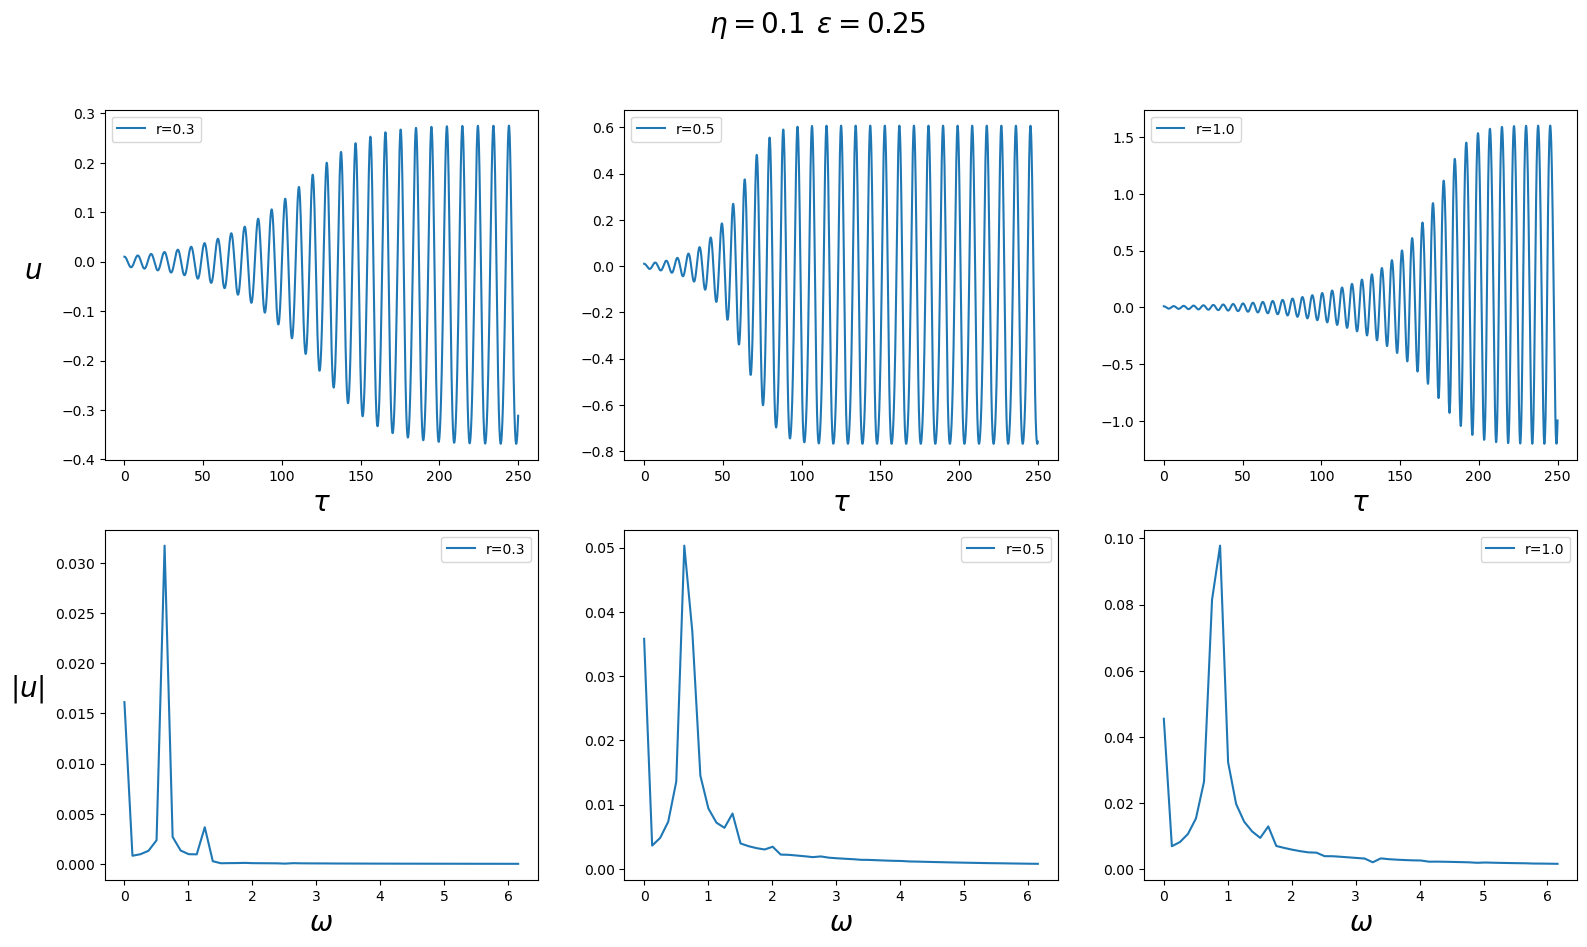

In [85]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=2.5e2             ### DO NOT increase this by a lot
N_step=1000*2
f_range=[int(0.8*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//8)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

fig, axs = plt.subplots(2, 3,figsize=(19,10))
psi_0=np.array([1e-2,0])
r_list=[0.3,0.5,1.0]
for i,r in enumerate(tqdm(r_list)):
    label="r={0}".format(r)
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step)
    zz_f=np.abs(np.fft.fft(zz[0][f_range[0]:f_range[1]]))[:(f_range[1]-f_range[0])//8]/N_step
    axs[0,i].plot(t,zz[0],label=label)
    axs[1,i].plot(omega_list,zz_f,label=label)

#     axs[i].set_ylabel("$|\\varphi|$",fontsize=20)
    axs[0,i].set_xlabel('$\\tau$',fontsize=20)
    axs[1,i].set_xlabel('$\omega$',fontsize=20)

    axs[0,i].legend(loc='best')
    axs[1,i].legend(loc='best')

axs[0,0].set_ylabel("$u$",fontsize=20, rotation=0,labelpad=20)
axs[1,0].set_ylabel("$|u|$",fontsize=20, rotation=0,labelpad=20)
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)

# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("time_evol_with_fourier_var_r"+str(i)+".jpg")
i+=1
plt.show()  

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:18<00:00,  4.99s/it]


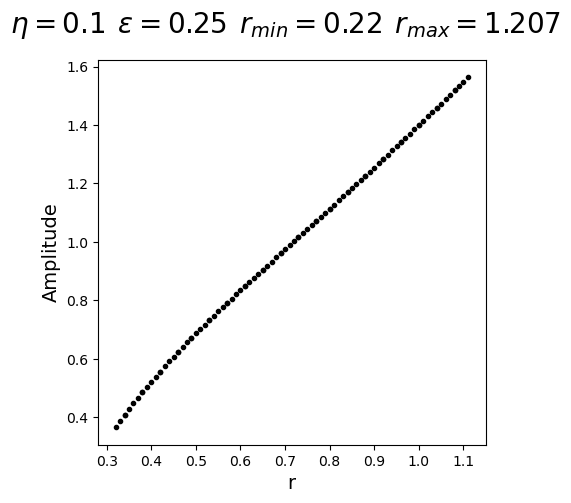

In [21]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=2e3             ### DO NOT increase this by a lot
N_step=10000
f_range=[int(0.9*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//32)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

N_grid=100
r_list=np.round(np.linspace(r_range[0]+1e-1,r_range[1]-1e-1,N_grid),2)
A_list=np.zeros(len(r_list))
psi_0=np.array([1e-2,0])

for i,r in enumerate(tqdm(r_list)):
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step,rtol = 1e-6, atol = 1e-6)
    zz_f=np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//32]/(f_range[1]-f_range[0])
    tp=2*np.pi/omega_list[np.argmax(np.abs(zz_f[10:]))]
    phi_sel=zz[0][-int(tp*N_step/tf):]
    A_list[i]=(np.max(phi_sel)-np.min(phi_sel))/2

fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(r_list,A_list,'.',color='k')
axs.set_xlabel("r",fontsize=14)
axs.set_ylabel("Amplitude",fontsize=14)
plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("Amp_vs_Detuning.jpg")
plt.show()

In [47]:
np.max(np.sin(np.linspace(-2*np.pi,2*np.pi,100)))

0.9998741276738751

<IPython.core.display.Latex object>

only one root found so trying bisection method
r_range= [0.22  1.207]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [08:32<00:00,  5.13s/it]


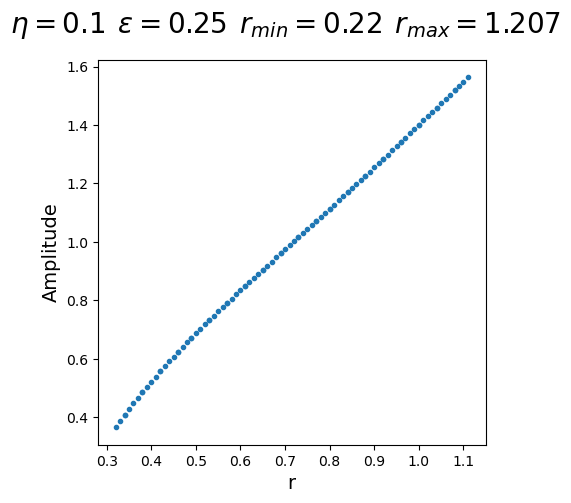

In [48]:
ohm=4e0
eta=0.1
r_range=np.round(amplification_info(eta,ohm),3)
print("r_range=",r_range)
   
tf=2e3             ### DO NOT increase this by a lot
N_step=10000
f_range=[int(0.9*N_step),N_step]
t_range=[int(f_range[0]*tf/N_step),int(f_range[1]*tf/N_step)]
omega_list=2*np.pi*np.arange((f_range[1]-f_range[0])//32)/(t_range[1]-t_range[0])

phi_0,phi_d_0=1e-3,0

N_grid=100
r_list=np.round(np.linspace(r_range[0]+1e-1,r_range[1]-1e-1,N_grid),2)
A_list=np.zeros(len(r_list))
psi_0=np.array([1e-2,0])

for i,r in enumerate(tqdm(r_list)):
    param_list=[ohm,r,eta] 
    zz,t=evolve(psi_0,tf,param_list,N_step,rtol = 1e-6, atol = 1e-6)
    zz_f=np.fft.fft(zz[0][f_range[0]:f_range[1]])[:(f_range[1]-f_range[0])//32]/(f_range[1]-f_range[0])
    tp=2*np.pi/omega_list[np.argmax(np.abs(zz_f[10:]))]
#     phi_sel=zz[0][-int(tp*N_step/tf):]
    phi_sel=zz[0][-100:]
    A_list[i]=(np.max(phi_sel)-np.min(phi_sel))/2

fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(r_list,A_list,'.')
axs.set_xlabel("r",fontsize=14)
axs.set_ylabel("Amplitude",fontsize=14)
plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=20)
plt.savefig("Amp_vs_Detuning.jpg")
plt.show()

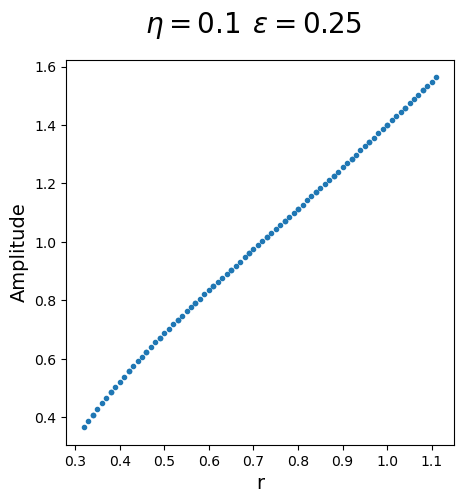

In [86]:
r_list=np.round(np.linspace(r_range[0]+1e-1,r_range[1]-1e-1,100),2)

fig, axs = plt.subplots(1, 1,figsize=(5,5))
axs.plot(r_list,A_list,'.')
axs.set_xlabel("r",fontsize=14)
axs.set_ylabel("Amplitude",fontsize=14)
plt.suptitle("$\eta={0} \: \: \epsilon={1}$".format(eta,1/ohm),fontsize=20)

# plt.suptitle("$\eta={0} \: \: \epsilon={1} \: \: r_{{min}}={2} \: \:r_{{max}}={3}$".format(eta,1/ohm,r_range[0],r_range[1]),fontsize=15)
plt.savefig("Amp_vs_Detuning.jpg")
plt.show()